# Montecarlo Dropout
in this notebook we want implement mc dropout



In [16]:
%load_ext autoreload
%autoreload 2
%cd /home/florian/GitRepos/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor

from src.globals import *
from src.visualization.show_image import show_image
from src.register_datasets import register_datasets, get_dataset_name
from src.config_builder import get_config

from src.active_learning.active_learning_trainer import *





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/florian/GitRepos/activeCell-ACDC
data		   log	   pipeline_configs  requirements.txt  src
jupyter_notebooks  output  README.md	     shell_scripts     wandb


In [17]:
DATASET = ACDC_SMALL
CONFIG_NAME = "acdc_small_al_20"


def plot_trio(image_json, dataset=DATASET, data_type=TEST, config_name=CONFIG_NAME):
    
    logger = setup_logger(output="./log/main.log")
    logger.setLevel(0)

    # ground truth
    print(image_json["file_name"])
    raw_im = cv2.imread(image_json["file_name"])

    visualizer = Visualizer(raw_im[:, :, ::-1], metadata=MetadataCatalog.get(get_dataset_name(dataset,data_type)), scale=2)
    out = visualizer.draw_dataset_dict(image_json)
    ground_truth_im = out.get_image()[:, :, ::-1]
    
    # prediction
    cfg = get_config(config_name)
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   # set a custom testing threshold
    predictor = DefaultPredictor(cfg)

    outputs = predictor(raw_im)
    
    v = Visualizer(raw_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))


    predicted_instances = np.asarray(outputs["instances"].pred_masks.to("cpu"))
    predicted_mask = np.zeros(predicted_instances[0].shape)

    for id in range(len(predicted_instances)):
        np.place(predicted_mask, predicted_instances[id], 1)

    predicted_im = out.get_image()[:, :, ::-1]


    visualizer = Visualizer(np.zeros(raw_im[:, :, ::-1].shape), metadata=MetadataCatalog.get(get_dataset_name(dataset,data_type)), scale=2)
    new_im_json = image_json.copy()
    new_im_json["annotations"] = []
    for anno in image_json["annotations"]:
        new_anno = anno.copy()
        new_anno["bbox"] = [0,0,0,0]
        new_im_json["annotations"].append(new_anno)
    out = visualizer.draw_dataset_dict(new_im_json)
    print(np.array(out.get_image()[:, :, ::-1]).shape)
    ground_truth_mask = (np.array(out.get_image()[:, :, ::-1]) != 0).max(axis=2).astype(np.uint8)
    ground_truth_mask = cv2.resize(ground_truth_mask*255, dsize=(predicted_mask.shape[1],predicted_mask.shape[0]), interpolation=cv2.INTER_CUBIC)


    print("############################################################################")
    print(image_json["file_name"])

    show_image([raw_im, ground_truth_im,predicted_im, ground_truth_mask, predicted_mask, (ground_truth_mask > 0) - predicted_mask])

In [18]:
running_on_server = os.getenv("IS_SERVER") == "true"
print("running on server:", running_on_server)
cfg = get_config("acdc_small_al_20")
al_trainer = ActiveLearningTrainer(cfg, is_test_mode=not running_on_server)
#al_trainer.run(dataset=ACDC_SMALL, query_strat=MC_DROPOUT)

running on server: False


In [19]:

wandb.init(project="activeCell-ACDC", name="", sync_tensorboard=True, mode="disabled")
al_trainer.query_strategy = MCDropoutSampler(cfg)


# define al dataset and specify what dataset to use
al_trainer.cfg.AL.DATASETS.TRAIN_UNLABELED = get_dataset_name(ACDC_SMALL,TRAIN)
al_trainer.cfg.DATASETS.TRAIN = (get_dataset_name(ACDC_SMALL,TRAIN),)
al_trainer.cfg.DATASETS.TEST = (get_dataset_name(ACDC_SMALL,TEST),)
al_trainer.al_dataset = ActiveLearingDataset(al_trainer.cfg)  

resume = False
#for i in range(1):
#    al_trainer.step(resume=(i>0))

#wandb.run.finish()



registering acdc_large dataset
registering acdc_small dataset
registering cellpose dataset
[12/10 08:52:20 d2.data.datasets.coco]: Loading ./data/acdc_small/train/cell_acdc_coco_ds.json takes 2.03 seconds.
WARNING [12/10 08:52:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/10 08:52:20 d2.data.datasets.coco]: Loaded 5784 images in COCO format from ./data/acdc_small/train/cell_acdc_coco_ds.json
update_labeled_data


In [43]:
al_trainer.step(resume)
resume = True

WARNING [12/10 09:11:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

WARNING [12/10 09:16:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.49s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.980
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.917
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ Io

In [24]:
df_json = DatasetCatalog.get(get_dataset_name(ACDC_SMALL,TRAIN))

[12/10 09:07:26 d2.data.datasets.coco]: Loading ./data/acdc_small/train/cell_acdc_coco_ds.json takes 2.53 seconds.
WARNING [12/10 09:07:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/10 09:07:26 d2.data.datasets.coco]: Loaded 5784 images in COCO format from ./data/acdc_small/train/cell_acdc_coco_ds.json


In [44]:
labeled_ids = al_trainer.al_dataset.labeled_ids
labeled_jsons = []
for labeled_id in labeled_ids:
    for js in df_json:
        if js["image_id"] == labeled_id:
            labeled_jsons.append(js)
            


./data/acdc_small/train/images/6_88HFVF.png
(422, 480, 3)
############################################################################
./data/acdc_small/train/images/6_88HFVF.png


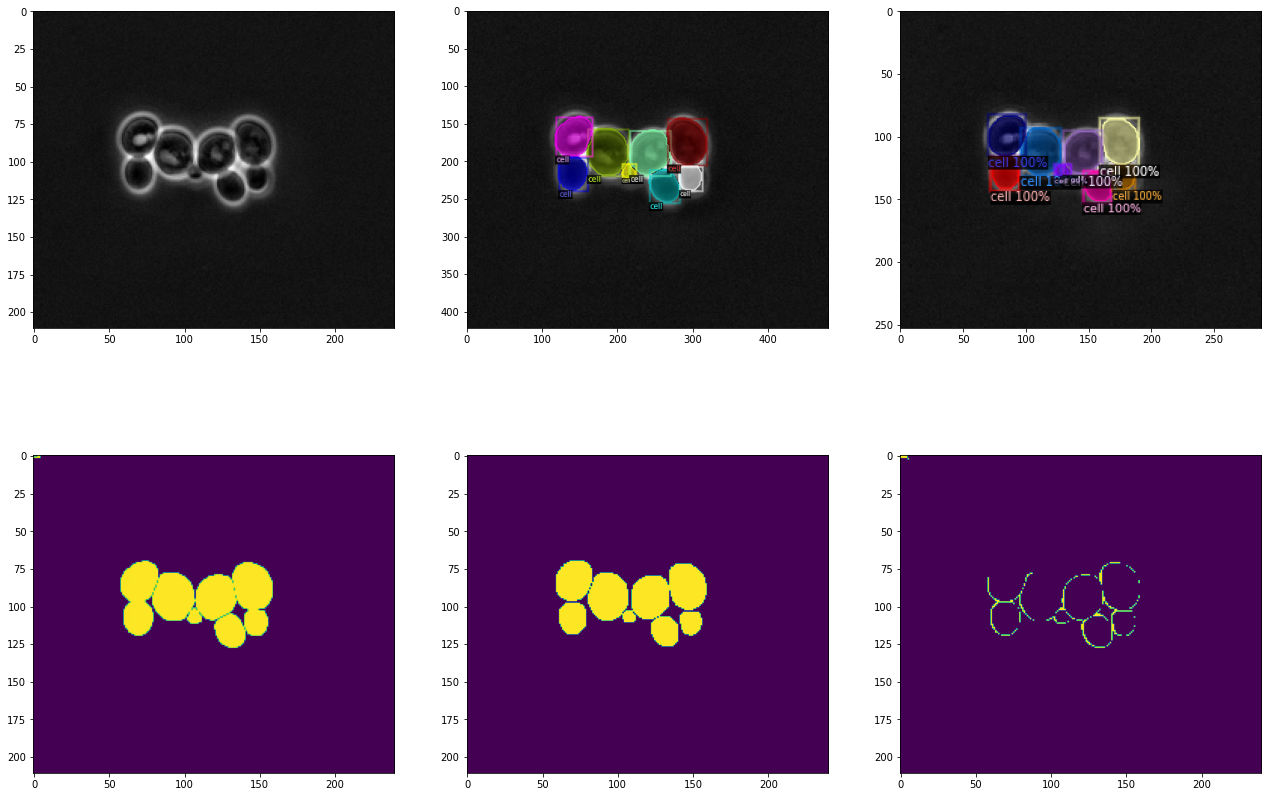

./data/acdc_small/train/images/2_100HFVF.png
(440, 488, 3)
############################################################################
./data/acdc_small/train/images/2_100HFVF.png


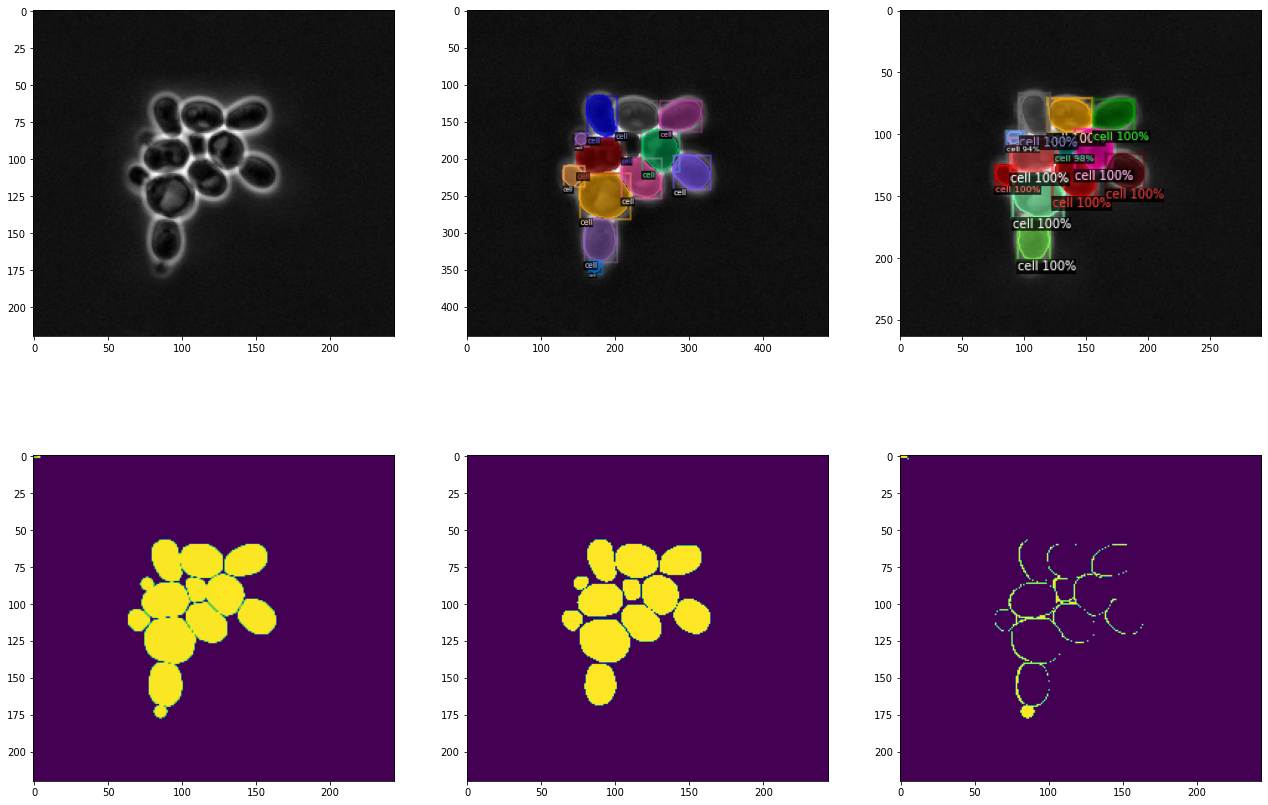

./data/acdc_small/train/images/6_66HFVF.png
(422, 480, 3)
############################################################################
./data/acdc_small/train/images/6_66HFVF.png


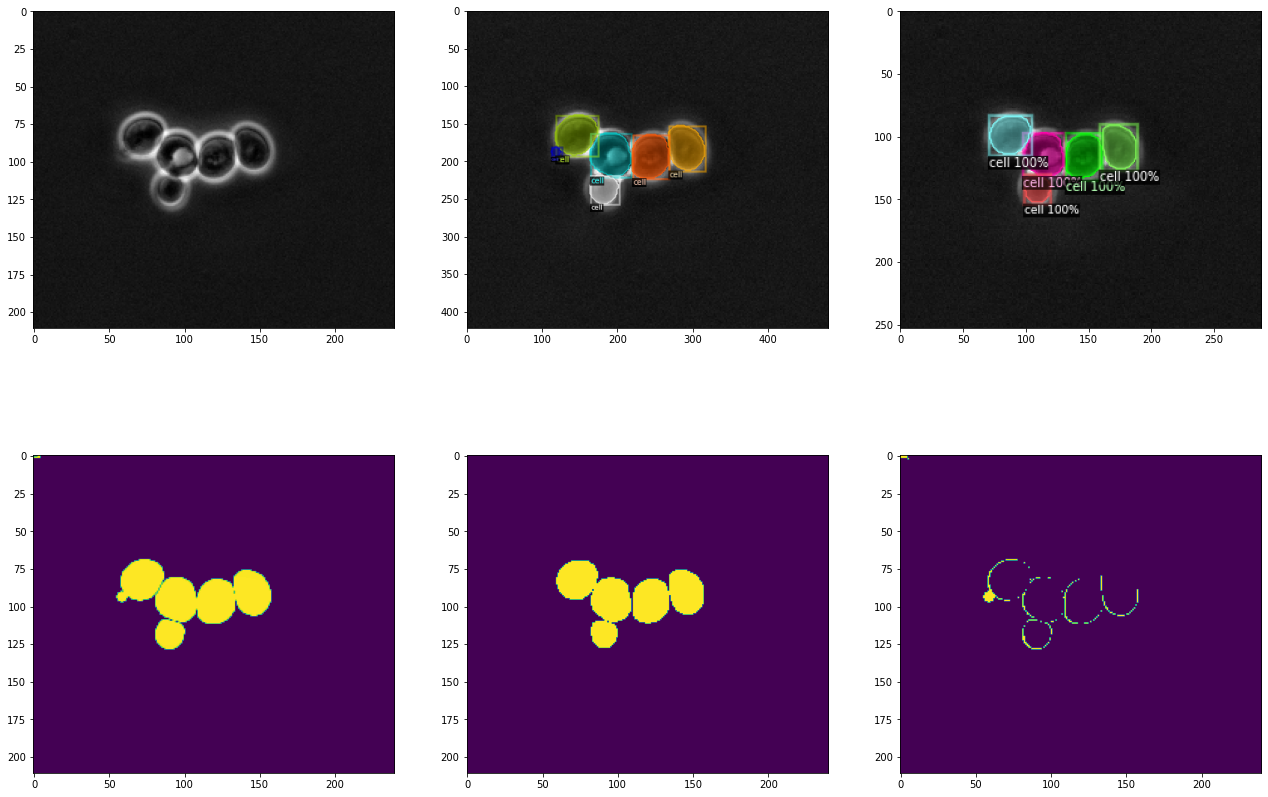

./data/acdc_small/train/images/6_14HFVF.png
(422, 480, 3)
############################################################################
./data/acdc_small/train/images/6_14HFVF.png


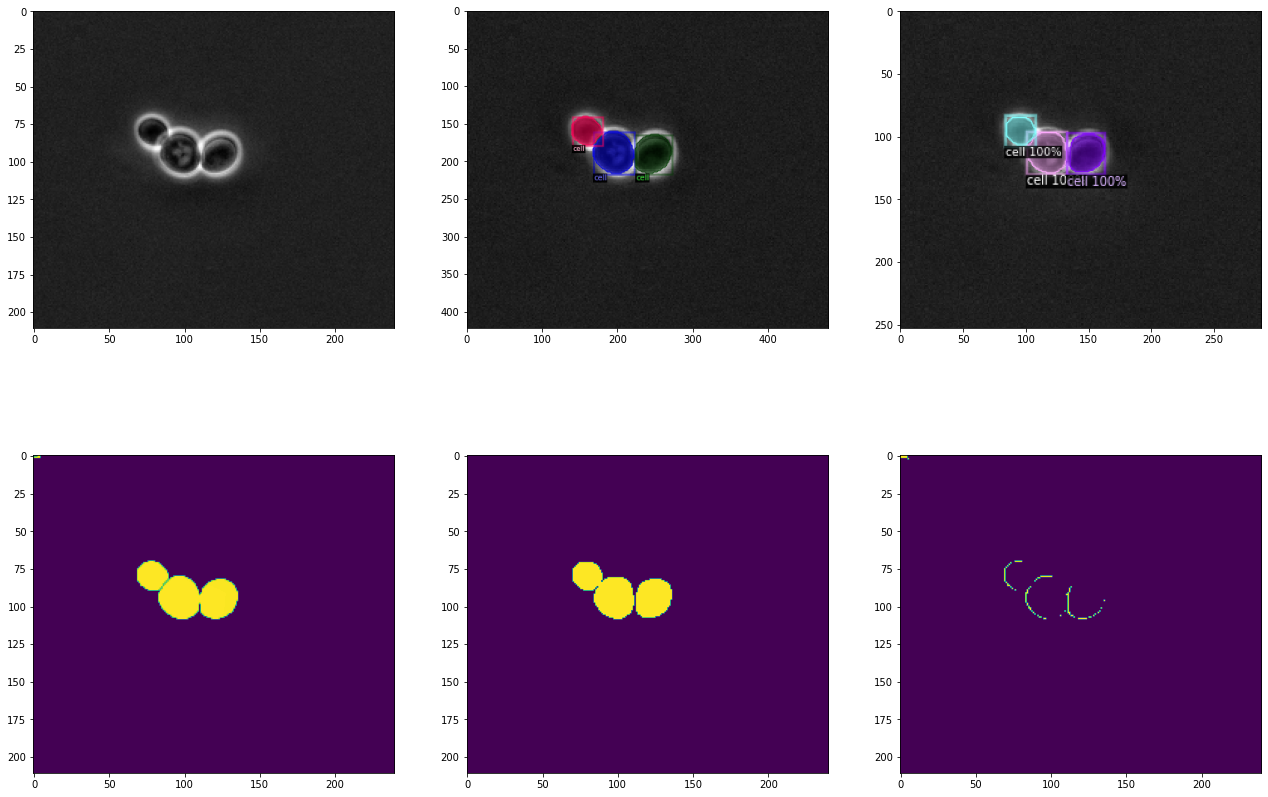

In [50]:
plot_trio(labeled_jsons[0])
plot_trio(labeled_jsons[-10])
plot_trio(labeled_jsons[-9])
plot_trio(labeled_jsons[-8])

In [48]:
[js["file_name"] for js in labeled_jsons][-10:]

['./data/acdc_small/train/images/2_100HFVF.png',
 './data/acdc_small/train/images/6_66HFVF.png',
 './data/acdc_small/train/images/6_14HFVF.png',
 './data/acdc_small/train/images/1_107HFVF.png',
 './data/acdc_small/train/images/5_133HFVF.png',
 './data/acdc_small/train/images/3_195HFVF.png',
 './data/acdc_small/train/images/6_183HFVF.png',
 './data/acdc_small/train/images/6_42HFVF.png',
 './data/acdc_small/train/images/4_56HFVF.png',
 './data/acdc_small/train/images/6_181HFVF.png']